# XGBoost Model

### Import Libraries

In [1]:
%matplotlib inline

import os
import time
from time import gmtime, strftime
import numpy as np
import pandas as pd
import boto3
import json
import io
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

In [2]:
# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

### Specify Input Data Location

In [3]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../input'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# s3 bucket and prefix (folder in s3)
bucket = session.default_bucket()
prefix = 'mle-capstone'

# location of datasets in s3
train_location = f's3://{bucket}/{prefix}/train.csv'
val_location = f's3://{bucket}/{prefix}/validation.csv'
test_location = f's3://{bucket}/{prefix}/test.csv'
Y_test_location = f's3://{bucket}/{prefix}/Y_test.csv'
test_unprocessed_location = f's3://{bucket}/{prefix}/test_unprocessed.csv'

## Train and construct the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct a training job for our XGBoost model and build the model itself.

### Set up the training job

First, we will set up and execute a training job for our model. To do this we need to specify some information that SageMaker will use to set up and properly execute the computation. For additional documentation on constructing a training job, see the [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) reference.

In [4]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = '246618743249.dkr.ecr.us-west-2.amazonaws.com'+'/sagemaker-xgboost:1.0-1-cpu-py3'

# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacts stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. You may wish to change these to see what effect
# there is on the resulting model.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "binary:logistic",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

[XGBoost Hyperparameter Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

### Execute the training job

Now that we've built the dictionary object containing the training job parameters, we can ask SageMaker to execute the job.

In [5]:
# First we need to choose a training job name. This is useful for if we want to recall information about our
# training job at a later date. Note that SageMaker requires a training job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
training_job_name = "starbucks-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

In [6]:
# monitor the job progress
session.logs_for_job(training_job_name, wait=True)

2021-03-03 09:26:20 Starting - Starting the training job...
2021-03-03 09:26:22 Starting - Launching requested ML instances......
2021-03-03 09:27:32 Starting - Preparing the instances for training......
2021-03-03 09:28:30 Downloading - Downloading input data...
2021-03-03 09:28:52 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[09:29:27] 25444x14 matrix with 356216 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter o

### Build the model

Now that the training job has completed, we have some model artifacts which we can use to build a model. Note that here we mean SageMaker's definition of a model, which is a collection of information about a specific algorithm along with the artifacts which result from a training job.

In [7]:
# We begin by asking SageMaker to describe for us the results of the training job. The data structure
# returned contains a lot more information than we currently need, try checking it out yourself in
# more detail.
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [8]:
# Just like when we created a training job, the model name must be unique
model_name = training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## Testing the model

Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can test our model. To do this we will make use of SageMaker's Batch Transform functionality. In other words, we need to set up and execute a batch transform job, similar to the way that we constructed the training job earlier.

### Set up the batch transform job

Just like when we were training our model, we first need to provide some information in the form of a data structure that describes the batch transform job which we wish to execute.

We will only be using some of the options available here but to see some of the additional options please see the SageMaker documentation for [creating a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTransformJob.html).

In [9]:
# Just like in each of the previous steps, we need to make sure to name our job and the name should be unique.
transform_job_name = 'mle-capstone-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # This is the name of the model that we created earlier.
    "ModelName": model_name,
    
    # This describes how many compute instances should be used at once. If you happen to be doing a very large
    # batch transform job it may be worth running multiple compute instances at once.
    "MaxConcurrentTransforms": 1,
    
    # This says how big each individual request sent to the model should be, at most. One of the things that
    # SageMaker does in the background is to split our data up into chunks so that each chunks stays under
    # this size limit.
    "MaxPayloadInMB": 6,
    
    # Sometimes we may want to send only a single sample to our endpoint at a time, however in this case each of
    # the chunks that we send should contain multiple samples of our input data.
    "BatchStrategy": "MultiRecord",
    
    # This next object describes where the output data should be stored. Some of the more advanced options which
    # we don't cover here also describe how SageMaker should collect output from various batches.
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-transform/".format(session.default_bucket(),prefix)
    },
    
    # Here we describe our input data. Of course, we need to tell SageMaker where on S3 our input data is stored, in
    # addition we need to detail the characteristics of our input data. In particular, since SageMaker may need to
    # split our data up into chunks, it needs to know how the individual samples in our data file appear. In our
    # case each line is its own sample and so we set the split type to 'line'. We also need to tell SageMaker what
    # type of data is being sent, in this case csv, so that it can properly serialize the data.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we would like it to use.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### Execute the batch transform job

Now that we have created the request data structure, it is time to ask SageMaker to set up and run our batch transform job. Just like in the previous steps, SageMaker performs these tasks in the background so that if we want to wait for the transform job to terminate (and ensure the job is progressing) we can ask SageMaker to wait of the transform job to complete.

In [10]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [11]:
transform_desc = session.wait_for_transform_job(transform_job_name)

.................................................................!


### Analyze the results

Now that the transform job has completed, the results are stored on S3 as we requested. Since we'd like to do a bit of analysis in the notebook we can use some notebook magic to copy the resulting output from S3 and save it locally.

In [12]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
transform_output

's3://sagemaker-us-west-2-785913330910/mle-capstone/batch-bransform/'

In [13]:
!aws s3 cp --recursive $transform_output $data_dir

In [14]:
# parse the s3uri
s3 = boto3.resource('s3')

s3uri = transform_request['TransformOutput']['S3OutputPath']

parsed_url = urlparse(s3uri)
batch_file = 'test.csv'

output_bucket_name = parsed_url.netloc
output_prefix = parsed_url.path[1:]
print(output_bucket_name)
print(output_prefix)
print(parsed_url)

sagemaker-us-west-2-785913330910
mle-capstone/batch-transform/
ParseResult(scheme='s3', netloc='sagemaker-us-west-2-785913330910', path='/mle-capstone/batch-transform/', params='', query='', fragment='')


In [15]:
# retrieve the test data object from s3
obj = s3.Object(bucket_name = output_bucket_name, key = 'mle-capstone/batch-transform/test.csv.out')

In [16]:
# get the result
result = obj.get()["Body"].read().decode('utf-8')

In [17]:
# retrieve the predicted probabilities
Y_pred_prob = pd.read_csv(io.StringIO(result), sep=",", header=None)

In [18]:
Y_pred_prob.shape

(12660, 1)

In [19]:
Y_pred_prob.head(10)

,0
0,0.830645
1,0.001296
2,0.911853
3,0.942162
4,0.001310
5,0.128885
6,0.001350
7,0.567132
8,0.945552
9,0.926978


In [20]:
# read the Y_test data from s3
Y_test = pd.read_csv(Y_test_location, header=None)
Y_test[:10]

,0
0,0
1,0
2,1
3,1
4,0
5,1
6,0
7,1
8,1
9,1


### Model Evaluation Metrics

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score

# Next we need to use our predicted probabilities to generate classifications
# set positive class threshold 
threshold = 0.5
y_pred_pos = Y_pred_prob[0]
y_pred_class = y_pred_pos > threshold

In [22]:
# Confusion Matrix and Accuracy
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_class).ravel()
# accuracy = (tp + tn) / (tp + fp + fn + tn)
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivty: {tp/(tp+fn)}")
print(f"Specificty: {tn/(tn+fp)}")
print(f"Accuracy: {(tp+tn)/((tp+ tn+fp+fn))}")
print(accuracy_score(Y_test, y_pred_class))
print(f1_score(Y_test, y_pred_class))

True Negatives: 4868
False Positives: 1671
False Negatives: 811
True Positives: 5310
Sensitivty: 0.8675053095899363
Specificty: 0.7444563388897385
Accuracy: 0.8039494470774091
0.8039494470774091
0.8105632727827813


The XGBoost model results in a slight improvement in the f1 score of 81.1% (vs 80.7% in our Linear Learner benchmark model.

Additionally, the XGboost model seems to do a better job of classifying the non converters than the Linear Learner model. The Specificity, or the proportion of the negative class that was predicted correctly, is the highest among the 3 models at 74% (vs 68% for the Linear Learner benchmark model). Though the proportion of the positive class (Sensitivity) is slightly lower at 87% compared to 91% in benchamrk model.

### Calculating Accuracy and F1 with Different Predicted Probability Thresholds

The default predicted probability threshold used to classify observations into the positve (conversions) and negative class (non-conversions) is 0.5.

It's often useful to see how using different thresholds can impact the evaluation metric of interest

In [23]:
# Loooping through a wide range of thresholds and classifying observations
f1_list = []
accuracy_list = []

thresholds = np.linspace(start = 0.05, stop = 0.9, num = 40)

for i in thresholds:
    temp_pred = [1 if x >= i else 0 for x in y_pred_pos]
    
    temp_f1 = f1_score(Y_test, temp_pred)
    temp_accuracy = accuracy_score(Y_test, temp_pred)
    
    f1_list.append(temp_f1)
    accuracy_list.append(temp_accuracy)

In [24]:
df_f1_accuracy = pd.DataFrame({'threshold': thresholds
                          , 'f1': f1_list
                          , 'accuracy': accuracy_list})
df_f1_accuracy

,threshold,f1,accuracy
0,0.050000,0.777198,0.723381
1,0.071795,0.778678,0.725829
2,0.093590,0.782263,0.731596
3,0.115385,0.785268,0.736572
4,0.137179,0.791580,0.746603
5,0.158974,0.792758,0.748657
6,0.180769,0.797244,0.755924
7,0.202564,0.800318,0.761769
8,0.224359,0.803640,0.768167
9,0.246154,0.804873,0.771011


In [25]:
# predicted probabilty that maximizes the f1 score
max_f1 = df_f1_accuracy['f1'].max()

print(df_f1_accuracy[df_f1_accuracy['f1'] == max_f1]['threshold'])
print(max_f1)

16    0.398718
Name: threshold, dtype: float64
0.8159261396422388


### Visualizing the Predicted Probabilites

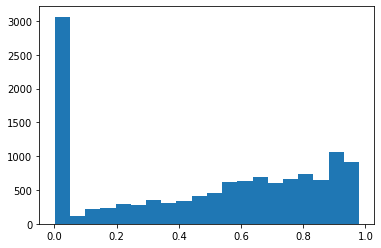

In [26]:
plt.hist(y_pred_pos, bins=20);

### Save the Predicted Probabilities

Next we'll do is to save the predicted probabilities to s3 so that we can easily use them for potential post hoc analysis

In [27]:
# storing results in a dataframe
df_pred_prob = pd.DataFrame({'y_pred_prob': y_pred_pos})

In [28]:
# save df to csv 
df_pred_prob.to_csv(os.path.join(data_dir, 'y_pred_prob_model_3.csv'), header=True, index=False)

In [29]:
# save to s3
y_pred_prob_model_3_location = session.upload_data(os.path.join(data_dir, 'y_pred_prob_model_3.csv'), bucket = bucket, key_prefix=prefix)